# Foldy-Lax
The Foldy-Lax formulation provides a way of calculating the wavefield around isotropic scatterers. In the case of $N$ point scatterers only an $N \times N$ matrix equation needs to be solved. The wavefield, $\phi$, must satisy the Helmholtz equation in free space:

$$\nabla^2 \phi + k^2 \phi = 0,$$

where $k$ is the wavenumber. If the incident waves satisfy the Helmholtz equation, so must the scattered waves. 
Therefore when a plane wave $e^{i\vec{k}.\vec{r}}$ is incident upon a point scatterer at $\vec{r_1}$, the scattered wavefield, $\phi_s$, must be a solution to

$$\nabla^2 \phi_s + k^2 \phi_s = \delta(\vec{r} - \vec{r_1}) \sigma_1 \phi_1$$

since a point scatterer of strength $\sigma_1$ in a wavefield of local amplitude $\phi_1$ acts like a source $\delta(\vec{r} - \vec{r_1}) \sigma_1 \phi_1$. We therefore have

$$\phi_s(\vec{r}) = \sigma_1 \phi_1 G(\vec{r}, \vec{r}_1),$$ 

for a single point scatterer, where $G$ is the Green's function of the Helmholtz equation. In 3D, 

$$G(\vec{r}, \vec{r_i}) = \frac{1}{4\pi} \frac{e^{ik|\vec{r}-\vec{r_i}|}}{|\vec{r}-\vec{r_i}|}.$$ 

For multiple scatterers we can simply add the scattered waves, this is because the Helmholtz equation is linear. The overall wavefield at $\vec{r}$ is

$$\phi(\vec{r}) = \phi_{inc}(\vec{r}) + \sum_j G(\vec{r}, \vec{r}_j) \sigma_j \phi_j,$$

where the sum is over point scatterers. Now to get the matrix equation out from that, set $\vec{r} = \vec{r_i}$ and exclude the self-interaction at scatterer $i$:

$$\phi_i - \sum_{j \neq i} G_{ij} \sigma_j \phi_j = \phi_{inc}(\vec{r_i}),$$
or in matrix form

$$\sum_j M_{ij} \phi_i = \phi_{inc}(\vec{r_i}),$$

$$M_{ij} = \delta_{ij} + (\delta_{ij} - 1) \sigma_j G_{ij}.$$

This matrix equation can be solved for the wave amplitudes at each scatterer. The amplitude at $\vec{r}$ is then given by the sum of the incident, $\phi_{inc}$, and scattered, $G(\vec{r}, \vec{r}_j) \sigma_j \phi_j$, waves.

In [15]:
%matplotlib inline
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

#set the incident wavevector
k = [3.0, 0.0, 0.0]
#and wavenumber
K = la.norm(k)

#define a point scatterer
class Scatterer:
    def __init__(self, position, strength):
        self.r = np.array(position)
        self.s = strength
        self.phi = 0.0 #wave amplitude at scatterer
    
#Green's function for 3D Helmholtz
def green(r1, r2):
    return np.exp(1.0j*K*la.norm(r1-r2))/(4.0*np.pi*la.norm(r1-r2))

def incident_wave(r, form):
    #r is a position vector
    incident_amplitude = 0.0j
    if form == 'plane':
        incident_amplitude = np.exp(1.0j*np.dot(k,r))
    elif form == 'spherical':
        incident_amplitude = np.exp(1.0j*K*la.norm(r))/la.norm(r)
    return incident_amplitude

#scattered amplitude from a single scatterer
def scattered_wave(scatterer, r):
    return (scatterer.s)*(scatterer.phi)*green(r,scatterer.r)

def Foldy_Lax(scatterers, incident_form, x, y):
    #x and y are 1D arrays of points at which amplitude is calculated
    #incident_form = 'spherical' or 'plane', form of incident wave
    #scatterers is a list of instances of Scatterer
    
    N = len(scatterers)
    #calculate the amplitude of the incident plane wave at each scatterer
    incident_amplitudes = [incident_wave(scatterers[i].r, incident_form) for i in range(N)]
    
    #calculate the elements of the matrix M (see above)
    M = np.zeros((N,N), dtype = np.complex128)
    for i in range(N):
        for j in range(N):
            if i == j:
                M[i][j] = 1.0
            else:
                M[i][j] = -(scatterers[j].s)*green(scatterers[i].r, scatterers[j].r)
                
    #solve for the amplitudes at each scatterer
    scatterer_amplitudes = la.solve(M, incident_amplitudes)
    for i in range(N):
        scatterers[i].phi = scatterer_amplitudes[i]
        
    #calculate the total wave amplitude at all values of x and y
    amplitudes = np.zeros((y.shape[0], x.shape[0]), dtype = np.complex128)
    for i in range(y.shape[0]):
        for j in range(x.shape[0]):
            r = [x[j],y[i],0.0]
            amplitudes[i][j] = incident_wave(r, incident_form)
            for scatterer in scatterers:
                amplitudes[i][j] += scattered_wave(scatterer, r)
    
    return amplitudes

## Scales
The idea of separation of scales is endemic in physics. In continuum mechanics we ignore the underlying atomic structure of matter; in atomic physics we often treat the nucleus as a point. 
In the context of interference and scattering, the wavelength sets the length scale of the problem. We therefore anticipate that structures on much smaller scales than this will be unimportant.

In the units of the plot axes, the wavelength is ~2.

In [28]:
x = np.linspace(-8,8,80)
y = np.linspace(-8,8,80)

#single point scatterer
position = np.array([0.0,0.0,0.0])
strength = 1.0
p1 = [Scatterer(position, strength)]

#calculate the amplitudes
amplitudes1 = Foldy_Lax(p1, 'plane', x, y)

### Single Scatterer
With only one point scatterer, the only lengthscale present in the problem is the wavelength. As a consequence, all of the features which appear in the interference pattern are on this scale.



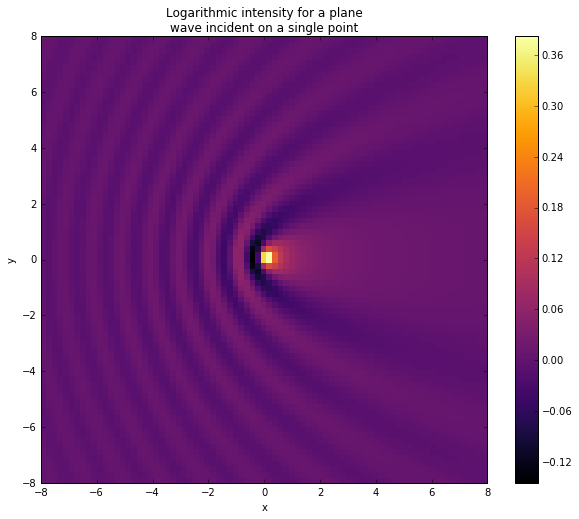

In [29]:
fig1 = plt.figure(figsize = (10,8))
plt.pcolor(x,y,np.log10(np.absolute(amplitudes1)**2), cmap = 'inferno')
plt.colorbar()
plt.title("Logarithmic intensity for a plane\nwave incident on a single point")
plt.xlabel('x')
plt.ylabel('y')

## Interference and Symmetry
In the following demonstrations, a single point source emits spherical monochromatic waves. The source is surrounded by perfect scatterers which reflect some of the incident radiation, creating interference fringes which respect the symmetry of the system. As the separation between the scatterers decreases below the order of a wavelength, circular symmetry begins to emerge in the wavefield.

In [30]:
#create a list of 5 point scatterers in a ring
N2 = 5
p2 = []
for i in range(N2):
    position = np.array([5.0*np.sin(2*np.pi*i/N2), 5.0*np.cos(2*np.pi*i/N2), 0.0])
    strength = 1.0
    p2.append(Scatterer(position, strength))

#calculate the amplitudes
amplitudes2 = Foldy_Lax(p2, 'spherical', x, y)

### Circle of 5 Scatterers
The separation of the scatterers is much larger than a wavelength. The wave can therefore resolve different scattering centres and the interference fringes are not circular. This can be seen from the shapes of the minima around each of the scatterers.

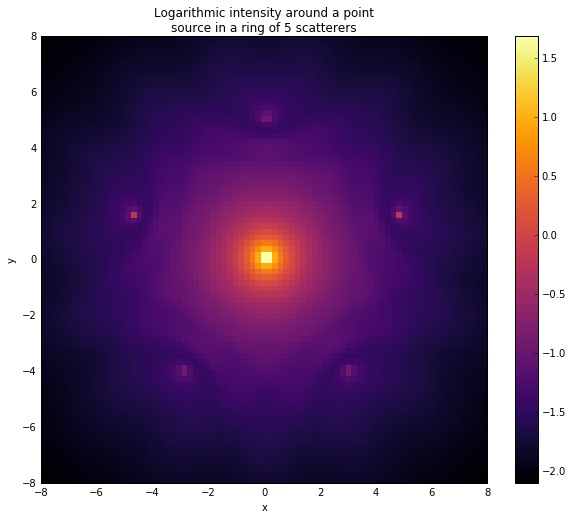

In [35]:
fig2 = plt.figure(figsize = (10,8))
plt.pcolor(x,y,np.log10(np.absolute(amplitudes2)**2), cmap = 'inferno')
plt.colorbar()
plt.title("Logarithmic intensity around a point\nsource in a ring of 5 scatterers")
plt.xlabel('x')
plt.ylabel('y')

In [20]:
#create a list of 20 point scatterers in a ring
N3 = 20
p3 = []
for i in range(N3):
    position = np.array([5.0*np.sin(2*np.pi*i/N3), 5.0*np.cos(2*np.pi*i/N3), 0.0])
    strength = 1.0
    p3.append(Scatterer(position, strength))

#calculate the amplitudes
amplitudes3 = Foldy_Lax(p3, 'spherical', x, y)

### Circle of 20 Scatterers
The scatterers are now separated by less than a wavelength, so cannot be resolved. The wave 'sees' a continuum of scatterers around the source; the interference pattern has near perfect circular symmetry.

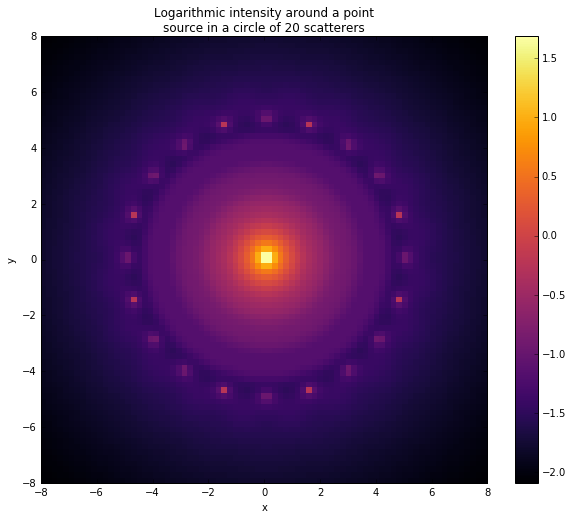

In [21]:
fig3 = plt.figure(figsize = (10,8))
plt.pcolor(x,y,np.log10(np.absolute(amplitudes3)**2), cmap = 'inferno')
plt.colorbar()
plt.title("Logarithmic intensity around a point\nsource in a circle of 20 scatterers")
plt.xlabel('x')
plt.ylabel('y')

In [22]:
#create a list of 20 point scatterers in an ellipse
N4 = 20
p4 = []
for i in range(N4):
    position = np.array([7.0*np.sin(2*np.pi*i/N4), 4.0*np.cos(2*np.pi*i/N4), 0.0])
    strength = 1.0
    p4.append(Scatterer(position, strength))

#calculate the amplitudes
amplitudes4 = Foldy_Lax(p4, 'spherical', x, y)

### Ellipse of 20 Scatterers
Both regimes are visible in this interference pattern. The scatterers are spaced by less than a wavelength at large $x$, so the wave sees them as continuous. This creates the large curved minima on the left and right of the plot. On the other hand, the scatterers near $x=0$ can be resolved by this wavelength, so the patterns around them are characteristic of point scatterers.

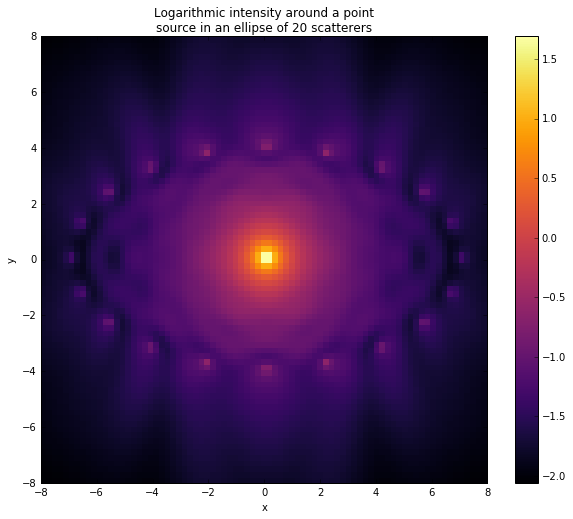

In [23]:
fig4 = plt.figure(figsize = (10,8))
plt.pcolor(x,y,np.log10(np.absolute(amplitudes4)**2), cmap = 'inferno')
plt.colorbar()
plt.title("Logarithmic intensity around a point\nsource in an ellipse of 20 scatterers")
plt.xlabel('x')
plt.ylabel('y')